In [1]:
import itertools
import pickle
import py3Dmol
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from biopandas.pdb import PandasPdb
from IPython.display import display, HTML
from ipywidgets import GridspecLayout, Output, VBox, Label, interactive_output, Dropdown, RadioButtons, interact
from openfold.np import residue_constants

from metfish.utils import get_rmsd, get_lddt, save_aligned_pdb, get_Pr

warnings.filterwarnings('ignore')

In [2]:
# setup data dirs
shared_dir = "/global/cfs/cdirs/m3513/metfish"
output_dir = "/global/cfs/cdirs/m3513/metfish/model_evaluation/msa_saxs_model/unfrozen_af_weights" # "/pscratch/sd/s/smprince/projects/metfish/model_evaluation"  
 
# load data dir and apo/holo pair information
test_data_df = pd.read_csv(f"{shared_dir}/apo_holo_data/input_no_training_data.csv")
apo_holo_df = pd.read_csv(f"{shared_dir}/apo_holo_data/apo_holo_pairs.csv")

pairs = list(zip(apo_holo_df['apo_id'], apo_holo_df['holo_id']))
names = test_data_df['name'].to_list()


## Compile data into dataframes



Define function to compile data for comparisons

In [3]:
def create_model_comparison_df(pairs, names, comparisons):
    # compile information for each apo/holo pair into a df
    data = []
    for name in names:
        # get pair info, skip if one of the pairs was in the training dataset
        name_alt = [(set(p) - {name}).pop() for p in pairs if name in p][0] 
        if name_alt not in test_data_df['name'].to_list():
            continue
        
        # load apo holo data
        rmsd_apo_holo = apo_holo_df.query('apo_id == @name | holo_id == @name')['rmsd_apo_holo'].values[0]

        # load alignment data
        fnames = dict(true=f"{shared_dir}/apo_holo_data/pdbs/{name}_atom_only.pdb",
                      true_alt=f"{shared_dir}/apo_holo_data/pdbs/{name_alt}_atom_only.pdb",
                      out=f"{output_dir}/{name}_MSASAXS_unrelaxed.pdb",
                      out_alt=f"{output_dir}/{name_alt}_MSASAXS_unrelaxed.pdb",
                      out_af=f"{output_dir}/{name}_AlphaFold_unrelaxed.pdb",)
        for (a, b) in comparisons:
            # load pdb data
            pdb_df_a = PandasPdb().read_pdb(fnames[a]).df['ATOM']
            pdb_df_b = PandasPdb().read_pdb(fnames[b]).df['ATOM']

            # get plddt values
            plddt_res_num_a = pdb_df_a.drop_duplicates('residue_number')['residue_number'].to_numpy()
            plddt_res_num_b = pdb_df_b.drop_duplicates('residue_number')['residue_number'].to_numpy()
            plddt_a = pdb_df_a.drop_duplicates('residue_number')['b_factor'].to_numpy()
            plddt_b = pdb_df_b.drop_duplicates('residue_number')['b_factor'].to_numpy()
            plddt_a = 100 - plddt_a if (a == 'true' or a == 'true_alt') else plddt_a  # if from pdb, convert b_factors to plddt
            plddt_b = 100 - plddt_b if (b == 'true' or b == 'true_alt') else plddt_b  # if from pdb, convert b_factors to plddt

            # calculate saxs curves
            r_a, p_of_r_a = get_Pr(fnames[a], name, None, 0.5)
            r_b, p_of_r_b = get_Pr(fnames[b], name, None, 0.5)

            # run comparisons / alignments[
            comparison = f'{a}_vs_{b}'
            rmsd = get_rmsd(pdb_df_a, pdb_df_b)
            lddt = get_lddt(pdb_df_a, pdb_df_b)
            save_aligned_pdb(fnames[a], fnames[b], comparison)

            # add comparisons
            data.append(dict(name=name,
                             name_alt=name_alt,
                            type_a=a,
                            type_b=b,
                            comparison=comparison,
                            rmsd=rmsd,
                            lddt=lddt,
                            plddt_a=plddt_a,
                            plddt_bins_a=plddt_res_num_a,
                            plddt_b=plddt_b,
                            plddt_bins_b=plddt_res_num_b,
                            saxs_bins_a=r_a,
                            saxs_a=p_of_r_a,
                            saxs_bins_b=r_b,
                            saxs_b=p_of_r_b,
                            rmsd_apo_holo=rmsd_apo_holo,
                            fname_a=fnames[a],
                            fname_b=fnames[b],))

    return pd.DataFrame(data)

### Compare alphafold outputs vs. msa saxs model outputs

In [4]:
types = ['out', 'true', 'out_af']
comparisons = list(itertools.combinations(types, 2))

df_af_saxs = create_model_comparison_df(pairs, names, comparisons)
df_af_saxs.head()

,name,name_alt,type_a,type_b,comparison,rmsd,lddt,plddt_a,plddt_bins_a,plddt_b,plddt_bins_b,saxs_bins_a,saxs_a,saxs_bins_b,saxs_b,rmsd_apo_holo,fname_a,fname_b
0,1AEL-12_A,1URE-8_A,out,true,out_vs_true,2.593371,0.603769,"[82.43, 91.59, 93.28, 94.34, 96.38, 96.82, 96....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.001099835049595718, 0.000702...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 9.933908677920072e-06, 0.0010947852...",2.6905,/global/cfs/cdirs/m3513/metfish/model_evaluati...,/global/cfs/cdirs/m3513/metfish/apo_holo_data/...
1,1AEL-12_A,1URE-8_A,out,out_af,out_vs_out_af,0.284021,0.995497,"[82.43, 91.59, 93.28, 94.34, 96.38, 96.82, 96....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[83.06, 89.5, 91.2, 93.17, 95.77, 96.34, 95.93...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.001099835049595718, 0.000702...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.0010975154215911473, 0.00069...",2.6905,/global/cfs/cdirs/m3513/metfish/model_evaluati...,/global/cfs/cdirs/m3513/metfish/model_evaluati...
2,1AEL-12_A,1URE-8_A,true,out_af,true_vs_out_af,2.566343,0.641023,"[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[83.06, 89.5, 91.2, 93.17, 95.77, 96.34, 95.93...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 9.933908677920072e-06, 0.0010947852...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.0010975154215911473, 0.00069...",2.6905,/global/cfs/cdirs/m3513/metfish/apo_holo_data/...,/global/cfs/cdirs/m3513/metfish/model_evaluati...
3,1VHL_A,1VIY_C,out,true,out_vs_true,2.455835,0.954948,"[56.99, 77.21, 89.83, 95.29, 96.91, 98.4, 98.2...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[62.59, 70.22, 80.68, 86.38, 88.78, 88.38, 88....","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 1.7527643911391034e-06, 4.50710843435769...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.0007517288648566979, 0.00045...",2.6096,/global/cfs/cdirs/m3513/metfish/model_evaluati...,/global/cfs/cdirs/m3513/metfish/apo_holo_data/...
4,1VHL_A,1VIY_C,out,out_af,out_vs_out_af,0.765092,0.992580,"[56.99, 77.21, 89.83, 95.29, 96.91, 98.4, 98.2...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[62.51, 82.99, 91.26, 97.17, 97.91, 98.62, 98....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 1.7527643911391034e-06, 4.50710843435769...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.0007187764831744724, 0.00046...",2.6096,/global/cfs/cdirs/m3513/metfish/model_evaluati...,/global/cfs/cdirs/m3513/metfish/model_evaluati...


## Compare apo vs. holo  data

In [5]:
comparisons = [('out', 'true'), ('out_alt', 'true_alt'),('out', 'out_alt')]
df_apo_holo = create_model_comparison_df(pairs, names, comparisons)
df_apo_holo.head()

,name,name_alt,type_a,type_b,comparison,rmsd,lddt,plddt_a,plddt_bins_a,plddt_b,plddt_bins_b,saxs_bins_a,saxs_a,saxs_bins_b,saxs_b,rmsd_apo_holo,fname_a,fname_b
0,1AEL-12_A,1URE-8_A,out,true,out_vs_true,2.593371,0.603769,"[82.43, 91.59, 93.28, 94.34, 96.38, 96.82, 96....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.001099835049595718, 0.000702...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 9.933908677920072e-06, 0.0010947852...",2.6905,/global/cfs/cdirs/m3513/metfish/model_evaluati...,/global/cfs/cdirs/m3513/metfish/apo_holo_data/...
1,1AEL-12_A,1URE-8_A,out_alt,true_alt,out_alt_vs_true_alt,1.618083,0.773966,"[81.92, 90.6, 92.49, 93.78, 95.9, 96.41, 95.66...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.001099835049595718, 0.000700...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 4.263172721025887e-05, 0.0010302926...",2.6905,/global/cfs/cdirs/m3513/metfish/model_evaluati...,/global/cfs/cdirs/m3513/metfish/apo_holo_data/...
2,1AEL-12_A,1URE-8_A,out,out_alt,out_vs_out_alt,0.039471,1.000000,"[82.43, 91.59, 93.28, 94.34, 96.38, 96.82, 96....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[81.92, 90.6, 92.49, 93.78, 95.9, 96.41, 95.66...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.001099835049595718, 0.000702...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.001099835049595718, 0.000700...",2.6905,/global/cfs/cdirs/m3513/metfish/model_evaluati...,/global/cfs/cdirs/m3513/metfish/model_evaluati...
3,1VHL_A,1VIY_C,out,true,out_vs_true,2.455835,0.954948,"[56.99, 77.21, 89.83, 95.29, 96.91, 98.4, 98.2...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[62.59, 70.22, 80.68, 86.38, 88.78, 88.38, 88....","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 1.7527643911391034e-06, 4.50710843435769...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.0007517288648566979, 0.00045...",2.6096,/global/cfs/cdirs/m3513/metfish/model_evaluati...,/global/cfs/cdirs/m3513/metfish/apo_holo_data/...
4,1VHL_A,1VIY_C,out_alt,true_alt,out_alt_vs_true_alt,2.888070,0.949709,"[57.38, 77.27, 90.01, 95.5, 97.06, 98.45, 98.3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[64.41, 67.69, 79.5, 88.33, 89.92, 89.42, 91.7...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 7.511847390596158e-07, 4.507108434357695...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.0007269322031985482, 0.00045...",2.6096,/global/cfs/cdirs/m3513/metfish/model_evaluati...,/global/cfs/cdirs/m3513/metfish/apo_holo_data/...


## Compare group results

In [6]:
# setup plotting params
plt.rcParams.update({'font.size': 12})
color_scheme = {"Ground truth":"#5c5c5c",                     # grey
                "Ground truth alt":"#d1d1d1",                 # light grey
                    "AF output":"#2b2b2b",                   # dark grey
                    "SAXS output":"#b13c6c",                      # purple
                    "SAXS output alt":"#96acd2",                  # blue
                    "Ground truth vs. SAXS output":"#e3685c",              # purple
                    "AF output vs. SAXS output":"#2b2b2b",            # dark grey
                    "Ground truth vs. AF output":"#5c5c5c",           # grey    
                    "Ground truth alt vs. SAXS output alt":"#96acd2",      # blue
                    "SAXS output vs. SAXS output alt":"#264882",  # dark blue
               }
label_dict = dict(true="Ground truth",                     
                    true_alt="Ground truth alt",                 
                    out_af="AF output",                   
                    out="SAXS output",                      
                    out_alt="SAXS output alt",                  
                    out_vs_true="Ground truth vs. SAXS output",            
                    out_vs_out_af="AF output vs. SAXS output",           
                    true_vs_out_af="Ground truth vs. AF output",          
                    out_alt_vs_true_alt="Ground truth alt vs. SAXS output alt",
                    out_vs_out_alt="SAXS output vs. SAXS output alt"
                    )


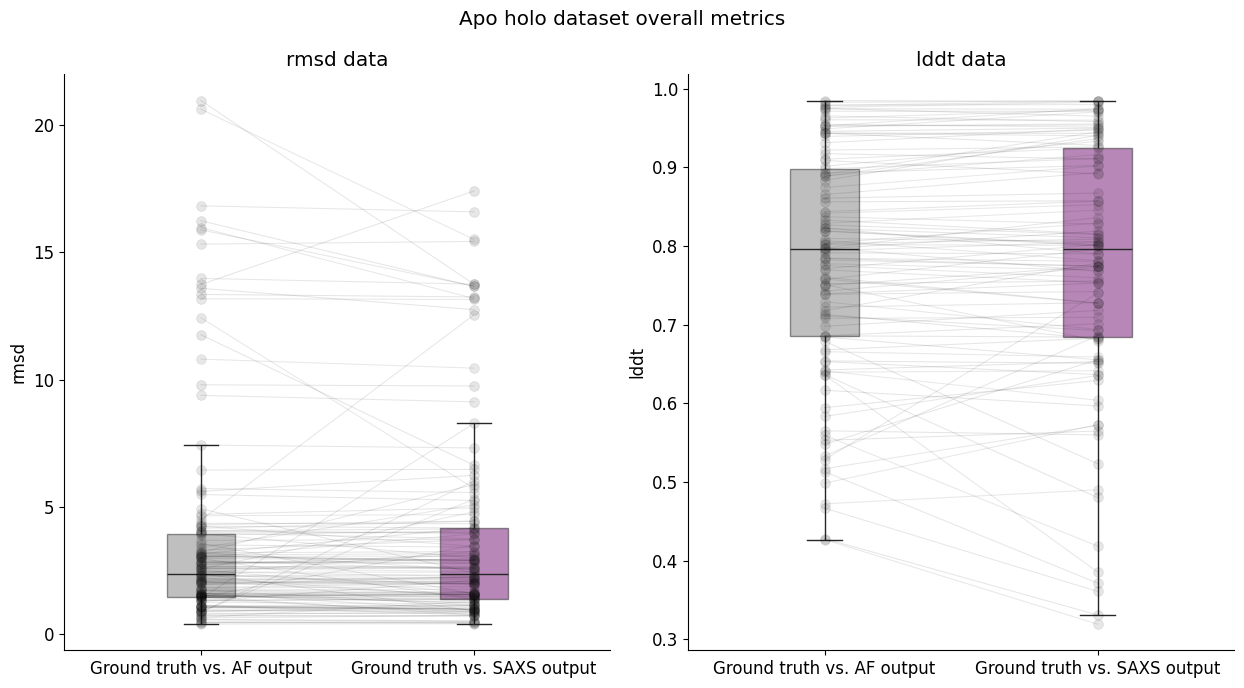

In [7]:
comparisons = ["true_vs_out_af", "out_vs_true"]
metrics = ['rmsd', 'lddt']
group_df = (df_af_saxs[['name', 'comparison', 'rmsd', 'lddt', 'rmsd_apo_holo']]
            .query(f'comparison in {comparisons}')
            .melt(id_vars=['name', 'comparison', 'rmsd_apo_holo'], value_vars=['rmsd', 'lddt'], var_name='metric', value_name='value'))
group_df
for col in ['comparison']:
    group_df[f'labels_{col}'] = group_df[col].map(label_dict)


g = sns.catplot(data=group_df, x='labels_comparison', y='value', col='metric', hue='name', kind='point', order=["Ground truth vs. AF output", "Ground truth vs. SAXS output"],
            capsize=0, errorbar=None, markersize=7, palette='dark:k', alpha=0.1, linewidth=0.75, legend=False,
            sharey=False, height=7, aspect=0.9)

for i, ax in enumerate(g.axes[0]):
    sns.boxplot(ax=ax,
        data=group_df.query(f'metric == "{metrics[i]}"'), x='labels_comparison', y='value', hue='labels_comparison', order=["Ground truth vs. AF output", "Ground truth vs. SAXS output"], palette=['purple', 'grey',],
        showfliers=False, width=0.25, zorder=-1,boxprops=dict(alpha=.5)
    )
    ax.set(title=f'{metrics[i]} data', xlabel=None, ylabel=metrics[i])
plt.suptitle("Apo holo dataset overall metrics")
plt.tight_layout()

## Compare single sequence predictions

In [8]:
# define plotting function
def update_plot(name, df_name):
    if df_name == "Alphafold vs. SAXS output":
        df = df_af_saxs
    elif df_name == 'Apo vs. Holo SAXS output':
        df = df_apo_holo
    data = (df.query('name == @name'))
    for col in ['type_a', 'type_b', 'comparison']:
        data[f'labels_{col}'] = data[col].map(label_dict)
    
    # prep data
    subset_df = (pd.concat([data[['labels_type_a', 'saxs_bins_a', 'saxs_a', 'plddt_bins_a', 'plddt_a', 'fname_a']].rename(columns=lambda x: x.rstrip('_a')),
                    data[['labels_type_b', 'saxs_bins_b', 'saxs_b', 'plddt_bins_b', 'plddt_b', 'fname_b']].rename(columns=lambda x: x.rstrip('_b'))])
            .drop_duplicates('labels_type'))
    saxs_data = subset_df[['labels_type', 'saxs_bins', 'saxs']].explode(['saxs_bins', 'saxs'])
    palette = {k: color_scheme[k] for k in saxs_data['labels_type'].unique()}
    comp_palette = {k: color_scheme[k] for k in data['labels_comparison'].unique()}

    # setup figure
    grid = GridspecLayout(3, 3, height='400', width='300', height_ratios=[1, 3, 1])

    # plot saxs data
    out1 = Output()
    with out1:
        fig, ax = plt.subplots(1, 3, figsize=(15, 6), width_ratios=[3, 1, 1])
        sns.lineplot(data=saxs_data, x='saxs_bins', y='saxs',
                hue='labels_type', hue_order=palette.keys(), palette=palette.values(), ax=ax[0], linewidth=2)
        sns.lineplot(data=saxs_data.query('labels_type == "SAXS output"'), x='saxs_bins', y='saxs', color=palette["SAXS output"], ax=ax[0], zorder=10, linewidth=2)
        ax[0].set(title = 'SAXS data', xlabel='r', ylabel='P(r)')

        subset_data = data.query('labels_comparison != "AF output vs. SAXS output"')
        subset_palette = {k: v for k, v in comp_palette.items() if k != "AF output vs. SAXS output"}
        sns.pointplot(y='labels_comparison', x='rmsd', hue='labels_comparison', data=subset_data, markersize=10, order=subset_palette.keys(), palette=subset_palette.values(), ax=ax[1])
        ax[1].set(title='RMSD data', xlabel='RMSD', ylabel=None)

        sns.pointplot(y='labels_comparison', x='lddt', hue='labels_comparison', data=subset_data, markersize=10, order=subset_palette.keys(), palette=subset_palette.values(), ax=ax[2])
        ax[2].set(title='LDDT data', xlabel='LDDT', ylabel=None) 

        fig.suptitle(name, fontsize=20)  
        fig.tight_layout()
        sns.despine()
        plt.show()
    grid[0, :] = out1

    # plot viewers
    out4 = Output()
    with out4:
        view = py3Dmol.view(width='300', viewergrid=(1, len(comp_palette)))
        # compare different models
        for col_id, (comp, color) in enumerate(comp_palette.items()):
                type_a = data.query('labels_comparison == @comp')['type_a'].values[0]
                type_b = data.query('labels_comparison == @comp')['type_b'].values[0]
                fname_a = data.query('labels_comparison == @comp')['fname_a'].values[0]
                fname_b = f"{data.query('labels_comparison == @comp')['fname_b'].values[0].rstrip('.pdb')}_aligned_{type_a}_vs_{type_b}.pdb"

                view.addModel(open(fname_a, 'r').read(), 'pdb', viewer=(0, col_id))
                view.addModel(open(fname_b, 'r').read(), 'pdb', viewer=(0, col_id))
                view.setStyle({'model': 0}, {"cartoon": {'color': color_scheme[label_dict[type_a]]}}, viewer=(0, col_id))
                view.setStyle({'model': 1}, {"cartoon": {'color': color_scheme[label_dict[type_b]]}}, viewer=(0, col_id))
                view.addLabel(label_dict[type_a],
                              {'position': {'x': 0, 'y': 10, 'z': 0}, 'backgroundColor': 'white', 'fontColor': color_scheme[label_dict[type_a]], 'fontSize': 14}, 
                              viewer=(0, col_id))
                view.addLabel(label_dict[type_b], 
                              {'position': {'x': 0, 'y': 20, 'z': 0}, 'backgroundColor': 'white', 'fontColor': color_scheme[label_dict[type_b]], 'fontSize': 14}, 
                              viewer=(0, col_id))
        view.zoomTo()
        view.show()
    grid[1,:] = out4

    # plot plddt data
    out5 = Output()
    with out5:
        fig, ax = plt.subplots(1, 1)
        plddt_data = subset_df[['labels_type', 'plddt_bins', 'plddt']].explode(['plddt_bins', 'plddt'])
        sns.lineplot(data=plddt_data, x='plddt_bins', y='plddt',
                hue='labels_type', hue_order=palette.keys(), palette=palette.values(), ax=ax)
        sns.lineplot(data=plddt_data.query('labels_type == "SAXS output"'), x='plddt_bins', y='plddt', color=palette["SAXS output"], ax=ax, zorder=10)
        ax.set(title='pLDDT data', xlabel='Residue number', ylabel='pLDDT score')
        sns.despine()
        plt.show()
    grid[2, 0] = out5

    out5 = Output()
    with out5:
        view = py3Dmol.view(width='300', viewergrid=(1, len(palette)))

        for col_id, (type_a, color) in enumerate(palette.items()):
                if type_a != "SAXS output" and type_a != "SAXS output alt":
                    type_b_name = data.query('labels_type_b == @type_a')['type_b'].values[0]
                    type_a_name = 'out' if 'alt' not in type_a else 'out_alt'
                    fname = f"{subset_df.query('labels_type == @type_a')['fname'].values[0].rstrip('.pdb')}_aligned_{type_a_name}_vs_{type_b_name}.pdb"
                else:
                    fname = subset_df.query('labels_type == @type_a')['fname'].values[0]
                view.addModel(open(fname, 'r').read(), 'pdb', viewer=(0, col_id))
                view.setStyle({'model': 0}, {'cartoon': {'colorscheme': {'prop': 'b', "gradient": "roygb", "min": 50, "max": 90}}}, viewer=(0, col_id))
                view.addLabel(type_a,
                              {'position': {'x': 0, 'y': 10, 'z': 0}, 'backgroundColor': 'white', 'fontColor': color_scheme[type_a], 'fontSize': 14}, 
                              viewer=(0, col_id))
        view.zoomTo()
        view.show()
    grid[2, 1:] = out5
    display(grid)

In [11]:
dropdown = Dropdown(
    options=df_af_saxs['name'].unique(),
    value='1EQM_A',
    description='Sequence:',
)
radio = RadioButtons(
    options=['Alphafold vs. SAXS output', 'Apo vs. Holo SAXS output'],
    value='Alphafold vs. SAXS output',
    description='Comparison:',
)

out = interact(update_plot, name=dropdown, df_name=radio);

interactive(children=(Dropdown(description='Sequence:', index=20, options=('1AEL-12_A', '1VHL_A', '3UC5_A', '1…